# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Baselines

* This notebook evaluates standard classifiers from scikit-learn on the provided features.
* Moreover, it evaluates Deep Learning models on both audio and spectrograms.

In [1]:
import time
import os

import IPython.display as ipd
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.models import Model
from keras.layers import  Flatten, Reshape, MaxPooling2D, concatenate
from keras.layers import Input,AveragePooling2D,Activation, Dense, Conv1D, Conv2D, MaxPooling1D

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier

import utils

In [2]:
AUDIO_DIR = os.environ.get('AUDIO_DIR')

tracks = utils.load('data/fma_metadata/tracks.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, features.shape, echonest.shape

((106574, 52), (106574, 518), (13129, 249))

## Subset

In [3]:
subset = tracks.index[tracks['set', 'subset'] <= 'medium']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((25000, 52), (25000, 518))

In [4]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
#genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres))
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))

19922 training examples, 2505 validation examples, 2573 testing examples
Top genres (16): ['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken']
All genres (151): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 37, 38, 41, 42, 43, 45, 46, 47, 49, 53, 58, 63, 64, 65, 66, 70, 71, 74, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 97, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 137, 138, 166, 167, 169, 171, 172, 174, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 311, 314, 322, 337, 359, 360, 361, 362, 374, 378, 400, 401, 404, 428, 439, 440, 441, 442, 443, 456, 468, 491, 495, 502, 504, 514, 524, 538, 539, 542, 580, 602, 619, 651, 659, 695, 741, 763, 808, 810, 811, 906, 1032, 1060, 1193, 1235]


## 1 Multiple classifiers and feature sets

Todo:
* Cross-validation for hyper-parameters.
* Dimensionality reduction?

### 1.1 Pre-processing

In [5]:
def pre_process(tracks, features, columns, multi_label=False, verbose=False):
    if not multi_label:
        # Assign an integer value to each genre.
        enc = LabelEncoder()
        labels = tracks['track', 'genre_top']
        #y = enc.fit_transform(tracks['track', 'genre_top'])
    else:
        # Create an indicator matrix.
        enc = MultiLabelBinarizer()
        labels = tracks['track', 'genres_all']
        #labels = tracks['track', 'genres']

    # Split in training, validation and testing sets.
    y_train = enc.fit_transform(labels[train])
    y_val = enc.transform(labels[val])
    y_test = enc.transform(labels[test])
    X_train = features.loc[train, columns].values
    X_val = features.loc[val, columns].values
    X_test = features.loc[test, columns].values
    
    print(len(y_train[0]))
    
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
    # Standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_val)
    scaler.transform(X_test)
    
    return y_train, y_val, y_test, X_train, X_val, X_test

### 1.2 Single genre

In [6]:
"""def test_classifiers_features(classifiers, feature_sets, multi_label=False):
    columns = list(classifiers.keys()).insert(0, 'dim')
    scores = pd.DataFrame(columns=columns, index=feature_sets.keys())
    times = pd.DataFrame(columns=classifiers.keys(), index=feature_sets.keys())
    for fset_name, fset in tqdm_notebook(feature_sets.items(), desc='features'):
        y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset, multi_label)
        scores.loc[fset_name, 'dim'] = X_train.shape[1]
        for clf_name, clf in classifiers.items():  # tqdm_notebook(classifiers.items(), desc='classifiers', leave=False):
            t = time.process_time()
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            scores.loc[fset_name, clf_name] = score
            times.loc[fset_name, clf_name] = time.process_time() - t
    return scores, times

def format_scores(scores):
    def highlight(s):
        is_max = s == max(s[1:])
        return ['background-color: yellow' if v else '' for v in is_max]
    scores = scores.style.apply(highlight, axis=1)
    return scores.format('{:.2%}', subset=pd.IndexSlice[:, scores.columns[1]:])"""

"def test_classifiers_features(classifiers, feature_sets, multi_label=False):\n    columns = list(classifiers.keys()).insert(0, 'dim')\n    scores = pd.DataFrame(columns=columns, index=feature_sets.keys())\n    times = pd.DataFrame(columns=classifiers.keys(), index=feature_sets.keys())\n    for fset_name, fset in tqdm_notebook(feature_sets.items(), desc='features'):\n        y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset, multi_label)\n        scores.loc[fset_name, 'dim'] = X_train.shape[1]\n        for clf_name, clf in classifiers.items():  # tqdm_notebook(classifiers.items(), desc='classifiers', leave=False):\n            t = time.process_time()\n            clf.fit(X_train, y_train)\n            score = clf.score(X_test, y_test)\n            scores.loc[fset_name, clf_name] = score\n            times.loc[fset_name, clf_name] = time.process_time() - t\n    return scores, times\n\ndef format_scores(scores):\n    def highlight(s):\n        is_max

In [7]:
"""classifiers = {
    'LR': LogisticRegression(),
    'kNN': KNeighborsClassifier(n_neighbors=200),
    'SVCrbf': SVC(kernel='rbf'),
    'SVCpoly1': SVC(kernel='poly', degree=1),
    'linSVC1': SVC(kernel="linear"),
    'linSVC2': LinearSVC(),
    #GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    'DT': DecisionTreeClassifier(max_depth=5),
    'RF': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'AdaBoost': AdaBoostClassifier(n_estimators=10),
    'MLP1': MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000),
    'MLP2': MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=2000),
    'NB': GaussianNB(),
    'QDA': QuadraticDiscriminantAnalysis(),
}

feature_sets = {
#    'echonest_audio': ('echonest', 'audio_features'),
#    'echonest_social': ('echonest', 'social_features'),
#    'echonest_temporal': ('echonest', 'temporal_features'),
#    'echonest_audio/social': ('echonest', ('audio_features', 'social_features')),
#    'echonest_all': ('echonest', ('audio_features', 'social_features', 'temporal_features')),
}
for name in features.columns.levels[0]:
    feature_sets[name] = name
feature_sets.update({
    'mfcc/contrast': ['mfcc', 'spectral_contrast'],
    'mfcc/contrast/chroma': ['mfcc', 'spectral_contrast', 'chroma_cens'],
    'mfcc/contrast/centroid': ['mfcc', 'spectral_contrast', 'spectral_centroid'],
    'mfcc/contrast/chroma/centroid': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'],
    'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
    'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
    'all_non-echonest': list(features.columns.levels[0])
})

scores, times = test_classifiers_features(classifiers, feature_sets)

ipd.display(format_scores(scores))
ipd.display(times.style.format('{:.4f}'))"""

'classifiers = {\n    \'LR\': LogisticRegression(),\n    \'kNN\': KNeighborsClassifier(n_neighbors=200),\n    \'SVCrbf\': SVC(kernel=\'rbf\'),\n    \'SVCpoly1\': SVC(kernel=\'poly\', degree=1),\n    \'linSVC1\': SVC(kernel="linear"),\n    \'linSVC2\': LinearSVC(),\n    #GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),\n    \'DT\': DecisionTreeClassifier(max_depth=5),\n    \'RF\': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),\n    \'AdaBoost\': AdaBoostClassifier(n_estimators=10),\n    \'MLP1\': MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000),\n    \'MLP2\': MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=2000),\n    \'NB\': GaussianNB(),\n    \'QDA\': QuadraticDiscriminantAnalysis(),\n}\n\nfeature_sets = {\n#    \'echonest_audio\': (\'echonest\', \'audio_features\'),\n#    \'echonest_social\': (\'echonest\', \'social_features\'),\n#    \'echonest_temporal\': (\'echonest\', \'temporal_features\'),\n#    \'echonest_audio/social\': (\'echone

### 1.3 Multiple genres

Todo:
* Ignore rare genres? Count them higher up in the genre tree? On the other hand it's not much tracks.

In [8]:
"""classifiers = {
    #LogisticRegression(),
    'LR': OneVsRestClassifier(LogisticRegression()),
    'SVC': OneVsRestClassifier(SVC()),
    'MLP': MLPClassifier(max_iter=700),
}

feature_sets = {
#    'echonest_audio': ('echonest', 'audio_features'),
#    'echonest_temporal': ('echonest', 'temporal_features'),
    'mfcc': 'mfcc',
    'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
    'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
}

scores, times = test_classifiers_features(classifiers, feature_sets, multi_label=True)

ipd.display(format_scores(scores))
ipd.display(times.style.format('{:.4f}'))"""

"classifiers = {\n    #LogisticRegression(),\n    'LR': OneVsRestClassifier(LogisticRegression()),\n    'SVC': OneVsRestClassifier(SVC()),\n    'MLP': MLPClassifier(max_iter=700),\n}\n\nfeature_sets = {\n#    'echonest_audio': ('echonest', 'audio_features'),\n#    'echonest_temporal': ('echonest', 'temporal_features'),\n    'mfcc': 'mfcc',\n    'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],\n    'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],\n}\n\nscores, times = test_classifiers_features(classifiers, feature_sets, multi_label=True)\n\nipd.display(format_scores(scores))\nipd.display(times.style.format('{:.4f}'))"

## 2 Deep learning on raw audio

Other architectures:
* [Learning Features of Music from Scratch (MusicNet)](https://arxiv.org/abs/1611.09827), John Thickstun, Zaid Harchaoui, Sham Kakade.

In [9]:
labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

Load audio samples in parallel using `multiprocessing` so as to maximize CPU usage when decoding MP3s and making some optional pre-processing. There are multiple ways to load a waveform from a compressed MP3:
* librosa uses audioread in the backend which can use many native libraries, e.g. ffmpeg
    * resampling is very slow --> use `kaiser_fast`
    * does not work with multi-processing, for keras `fit_generator()`
* pydub is a high-level interface for audio modification, uses ffmpeg to load
    * store a temporary `.wav`
* directly pipe ffmpeg output
    * fastest method
* [pyAV](https://github.com/mikeboers/PyAV) may be a fastest alternative by linking to ffmpeg libraries

In [10]:
# Just be sure that everything is fine. Multiprocessing is tricky to debug.
utils.FfmpegLoader().load(utils.get_audio_path(AUDIO_DIR, 2))
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, utils.FfmpegLoader())
SampleLoader(train, batch_size=2).__next__()[0].shape


Ignoring ./data/fma_small/129/129354.mp3 (error: Command '['ffmpeg', '-i', './data/fma_small/129/129354.mp3', '-f', 's16le', '-acodec', 'pcm_s16le', '-ac', '1', '-']' returned non-zero exit status 1.).


(1, 1321967)

In [11]:
# Keras parameters.
NB_WORKER = len(os.sched_getaffinity(0))  # number of usables CPUs
params = {'pickle_safe': True, 'nb_worker': NB_WORKER, 'max_q_size': 10}

### 2.1 Fully connected neural network

* Two layers with 10 hiddens is no better than random, ~11%.

Optimize data loading to be CPU / GPU bound, not IO bound. Larger batches means reduced training time, so increase batch time until memory exhaustion. Number of workers and queue size have no influence on speed.

In [12]:
'''
loader = utils.FfmpegLoader(sampling_rate=2000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)
print('Dimensionality: {}'.format(loader.shape))

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Dense(output_dim=1000, input_shape=loader.shape))
model.add(Activation("relu"))
model.add(Dense(output_dim=100))
model.add(Activation("relu"))
model.add(Dense(output_dim=labels_onehot.shape[1]))
model.add(Activation("softmax"))

optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=64), train.size, nb_epoch=2, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=64), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=64), test.size, **params)
#Y = model.predict_generator(SampleLoader(test, batch_size=64), test.size, **params);

loss
'''

Dimensionality: (59953,)


TypeError: __init__() missing 1 required positional argument: 'units'

### 2.2 Convolutional neural network

* Architecture: [End-to-end learning for music audio](http://www.mirlab.org/conference_papers/International_Conference/ICASSP%202014/papers/p7014-dieleman.pdf), Sander Dieleman, Benjamin Schrauwen.
* Missing: track segmentation and class averaging (majority voting)
* Compared with log-scaled mel-spectrograms instead of strided convolution as first layer.
* Larger net: http://benanne.github.io/2014/08/05/spotify-cnns.html

In [ ]:
'''
loader = utils.FfmpegLoader(sampling_rate=16000)
#loader = utils.LibrosaLoader(sampling_rate=16000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Reshape((-1, 1), input_shape=loader.shape))
print(model.output_shape)

model.add(Conv1D(128, 512, subsample_length=512))
print(model.output_shape)
model.add(Activation("relu"))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

print(model.output_shape)
#model.add(Dropout(0.25))
model.add(Flatten())
print(model.output_shape)
model.add(Dense(100))
model.add(Activation("relu"))
print(model.output_shape)
model.add(Dense(labels_onehot.shape[1]))
model.add(Activation("softmax"))
print(model.output_shape)

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
#optimizer = keras.optimizers.Adam()#lr=1e-5)#, momentum=0.9, nesterov=True)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=10), train.size, nb_epoch=20, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=10), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=10), test.size, **params)

loss
'''

### 2.3 Our network (nnet1) from paper

In [18]:

loader = utils.FfmpegLoader(sampling_rate=16000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)

keras.backend.clear_session()



input_shape=[128,513,1]
inputs = Input(shape=input_shape)

conv1=Conv2D(kernel_size=(4,513),filters=128,activation="relu")(inputs)
pool1=MaxPooling2D( pool_size=(2, 1))(conv1)
conv2=Conv2D(kernel_size=(4,1),filters=128,activation="relu")(pool1)
pool2=MaxPooling2D( pool_size=(2, 1))(conv2)
conv3=Conv2D(kernel_size=(4,1),filters=256,activation="relu")(pool2)
# Average pooling layer
average_pool = AveragePooling2D(pool_size=(26,1))(conv3)
# Max pooling layer
max_pool = MaxPooling2D(pool_size=(26,1))(conv3)

# Concatenate the average pooling and max pooling outputs
merged = concatenate([average_pool, max_pool], axis=2)

# Flatten the output for the fully connected layers
flatten = Flatten()(merged)

# Dense layers
dense1 = Dense(300, activation='relu')(flatten)
dense2 = Dense(150, activation='relu')(dense1)
dense3 = Dense(10, activation='softmax')(dense2)

model = Model(inputs=inputs, outputs=dense3)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 513, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 125, 1, 128)  262784      input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 62, 1, 128)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 59, 1, 128)   65664       max_pooling2d[0][0]              
______________________________________________________________________________________________

### 2.4 creating the STFT training set

#### 2.4.1 Let's try with just one spectrogram

In [168]:
import librosa
import librosa.display
import utils
import os
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

AUDIO_DIR = os.environ.get('AUDIO_DIR')

#1 extract all track_id for fma_small + the label top_genre (by using track.csv) using only the train subset
#2 open the track with utils.get_audio_path(AUDIO_DIR, track_id).
#3 divide in 3s clips with 50% overlapping
#3 for each clip compute the stft using a frame of length 1024
#  with overlap of 50% (a hop of length 512) (and save in a file named with the track_id)


#first lets try to do an example with just one song
filename = utils.get_audio_path(AUDIO_DIR, 704)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True) #load the MONO instead of stereo as in paper
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))
print("**duration:",x.shape[-1]/sr)
print('Original sample rate: ',librosa.get_samplerate(filename))

#resample from 44100 to 22050 as in the paper
target_sr = sr//1 #leave 44100 for now
x = librosa.resample(x,orig_sr=sr, target_sr=target_sr)
print('New sample rate: ',target_sr)

#create a clip of the song
start, end = 7, 10
clip = x[start*sr:end*sr]
print('Duration in seconds of the clip:',(end-start))
print('Number of samples of the clip:',len(clip))


#calculate stft on the clip
stft = np.abs(librosa.stft(clip, n_fft=1024, hop_length=512))
print("Shape of the stft:",stft.shape)
#resize the spectrogram to become 512 x 128 instead of 512 x 130
stft = librosa.util.fix_length(stft, size=513, axis=0)[:, :128]

print("Shape of the resized stft:",stft.shape)
ipd.Audio(data=x_rs[start*target_sr:end*target_sr], rate=target_sr)

File: ./data/fma_small/000/000704.mp3
Duration: 29.98s, 1321967 samples
**duration: 29.976575963718822
Original sample rate:  44100
New sample rate:  44100
Duration in seconds of the clip: 3
Number of samples of the clip: 132300
Shape of the stft: (513, 259)
Shape of the resized stft: (513, 128)


#### 2.4.2 Let's try to get all the spectrograms for each 3s clip

start: 0  end: 3
start: 3  end: 6
start: 6  end: 9
start: 9  end: 12
start: 12  end: 15
start: 15  end: 18
start: 18  end: 21
start: 21  end: 24
start: 24  end: 27
start: 27  end: 30
shape of the stft vector:  (10, 513, 128)
Saving the stft for file: 000704


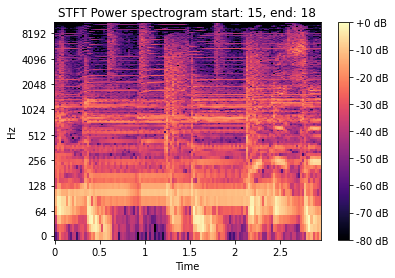

In [203]:
#now lets try to calculate stft on each 3s clip of the 30s song

stft_list = []

for i in range (0,28,3):
    start, end = i, i+3
    print('start:',start,' end:',end)
    
    #extract clip (TODO: IMPLEMENT 50% OVERLAPPING TO GET THE DOUBLE OF THE CLIPS)
    clip = x[start*sr:end*sr]
    
    #calculate stft
    stft = np.abs(librosa.stft(clip, n_fft=1024, hop_length=512))
    #print("Shape of the stft:",stft.shape)

    #resize the spectrogram to become 512 x 128 instead of 512 x 130
    stft = librosa.util.fix_length(stft, size=513, axis=0)[:, :128]
    #print("Shape of the resized stft:",stft.shape)
    
    stft_list.append(stft)
    
stft_array = np.array(stft_list)
print("shape of the stft vector: ", stft_array.shape)

filename_no_ext = filename.split("/")[-1].split(".")[0] #get filename without .mp3 and without path
print("Saving the stft for file:",filename_no_ext)

#save the stft array in a file with the name 'track_id.npy'
np.save('./data/fma_small_stft/filename_no_ext',stft_array)

fig, ax = plt.subplots()
clip_number = 5 #a number from 0 to 9
img = librosa.display.specshow(librosa.amplitude_to_db(stft_array[clip_number], ref=np.max), y_axis='log', x_axis='time', ax=ax)
ax.set_title('STFT Power spectrogram start: {}, end: {}'.format(3*clip_number,3*clip_number+3))
fig.colorbar(img, ax=ax, format="%+2.0f dB")

## Generate the STFT small dataset

#### Let's try to get all the spectrograms for all the audio in the dataset

In [206]:
#procedure: 
#1-get all the track ids for the small subset
#2-load each file
#3-compute its stft vector
#4-save the vector as a file

tracks = utils.load('data/fma_metadata/tracks.csv')

small = tracks[tracks['set', 'subset'] <= 'small']
small.shape

album                                                           \
         comments        date_created date_released engineer favorites  id   
track_id                                                                     
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4   1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4   1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4   6   
140             1 2008-11-26 01:49:59    2007-05-22      NaN         1  61   
141             0 2008-11-26 01:49:57    2009-01-16      NaN         1  60   

                                                                     \
                                                information listens   
track_id                                                              
2                                                   <p></p>    6073   
5                                                   <p></p>    6073   
10                                                      NaN   47632   
140       <p>Alec K. Redfearn &amp; The Eyesores: Ellen ...    1300   
141       <p>A full ensamble of strings, drums, electron...    1304   

                                               ...       track           \
                                producer tags  ... information interest   
track_id                                       ...                        
2                                    NaN   []  ...         NaN     4656   
5                                    NaN   []  ...         NaN     1933   
10                                   NaN   []  ...         NaN    54881   
140       Alec K. Refearn, Rob Pemberton   []  ...         NaN     1593   
141                                  NaN   []  ...         NaN      839   

                                                                           \
         language_code                                            license   
track_id                                                                    
2                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
5                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
10                  en  Attribution-NonCommercial-NoDerivatives (aka M...   
140                 en  Attribution-Noncommercial-No Derivative Works ...   
141                 en  Attribution-Noncommercial-No Derivative Works ...   

                                                                     
         listens lyricist number publisher tags               title  
track_id                                                             
2           1293      NaN      3       NaN   []                Food  
5           1151      NaN      6       NaN   []          This World  
10         50135      NaN      1       NaN   []             Freeway  
140         1299      NaN      2       NaN   []  Queen Of The Wires  
141          725      NaN      4       NaN   []                Ohio  

[5 rows x 52 columns]

In [251]:
#get the track ids
track_ids = np.array(small.index)
print("Track ids shape: ",track_ids.shape, "track ids content:",track_ids)

error_list = []

#open each track audio
for track_id in track_ids[track_ids>90000]:
    print("track id: ",track_id)
    
    try:
        #open the file using the utils
        filename = utils.get_audio_path(AUDIO_DIR, track_id)
        print('File: {}'.format(filename))

        x, sr = librosa.load(filename, sr=None, mono=True) #load the MONO instead of stereo as in paper
        print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

        #now lets try to calculate stft on each 3s clip of the 30s song

        stft_list = []

        for i in range (0,28,3):
            start, end = i, i+3
            #print('start:',start,' end:',end)

            #extract clip (TODO: IMPLEMENT 50% OVERLAPPING TO GET THE DOUBLE OF THE CLIPS)
            clip = x[start*sr:end*sr]

            #calculate stft
            stft = np.abs(librosa.stft(clip, n_fft=1024, hop_length=512))
            #print("Shape of the stft:",stft.shape)

            #resize the spectrogram to become 512 x 128 instead of 512 x 130
            stft = librosa.util.fix_length(stft, size=513, axis=0)[:, :128]
            #print("Shape of the resized stft:",stft.shape)

            stft_list.append(stft)

        stft_array = np.array(stft_list) #the final array containing the stft for each clip of the song
        print("shape of the stft vector: ", stft_array.shape)


        save_filename = './data/fma_small_stft/' + str(track_id)
        print("Saving the stft vector in file:",save_filename) 

        #save the stft array in a file with the name 'track_id.npy'
        np.save(save_filename,stft_array)
    except:
        print("ERROR on file: ",filename)
        error_list.append(filename)
#show plot for a single clip stft
'''
fig, ax = plt.subplots()
clip_number = 5 #a number from 0 to 9
img = librosa.display.specshow(librosa.amplitude_to_db(stft_array[clip_number], ref=np.max), y_axis='log', x_axis='time', ax=ax)
ax.set_title('STFT Power spectrogram start: {}, end: {}'.format(3*clip_number,3*clip_number+3))
fig.colorbar(img, ax=ax, format="%+2.0f dB")

'''
    
    

Track ids shape:  (8000,) track ids content: [     2      5     10 ... 154413 154414 155066]
track id:  90027
File: ./data/fma_small/090/090027.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/90027
track id:  90074
File: ./data/fma_small/090/090074.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/90074
track id:  90278
File: ./data/fma_small/090/090278.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/90278
track id:  90526
File: ./data/fma_small/090/090526.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/90526
track id:  90527
File: ./data/fma_small/090/090527.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the s

shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/91130
track id:  91157
File: ./data/fma_small/091/091157.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/91157
track id:  91158
File: ./data/fma_small/091/091158.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/91158
track id:  91159
File: ./data/fma_small/091/091159.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/91159
track id:  91160
File: ./data/fma_small/091/091160.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/91160
track id:  91161
File: ./data/fma_small/091/091161.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Sav

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/91755
track id:  91788
File: ./data/fma_small/091/091788.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/91788
track id:  91790
File: ./data/fma_small/091/091790.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/91790
track id:  91791
File: ./data/fma_small/091/091791.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/91791
track id:  91793
File: ./data/fma_small/091/091793.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/91793
track id:  91796
File: ./data/fma_small/091/091796.mp3
Duration: 29.98s, 1321967 samples
shape of th

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/92551
track id:  92554
File: ./data/fma_small/092/092554.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/92554
track id:  92556
File: ./data/fma_small/092/092556.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/92556
track id:  92561
File: ./data/fma_small/092/092561.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/92561
track id:  92562
File: ./data/fma_small/092/092562.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/92562
track id:  92564
File: ./data/fma_small/092/092564.mp3
Duration: 30.00s, 1323119 samples
shape of th

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/93716
track id:  93727
File: ./data/fma_small/093/093727.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/93727
track id:  93867
File: ./data/fma_small/093/093867.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/93867
track id:  93868
File: ./data/fma_small/093/093868.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/93868
track id:  93915
File: ./data/fma_small/093/093915.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/93915
track id:  93917
File: ./data/fma_small/093/093917.mp3
Duration: 29.98s, 1321967 samples
shape of th

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/94467
track id:  94468
File: ./data/fma_small/094/094468.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/94468
track id:  94628
File: ./data/fma_small/094/094628.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/94628
track id:  94630
File: ./data/fma_small/094/094630.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/94630
track id:  94631
File: ./data/fma_small/094/094631.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/94631
track id:  94632
File: ./data/fma_small/094/094632.mp3
Duration: 29.98s, 1321967 samples
shape of th

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/96403
track id:  96408
File: ./data/fma_small/096/096408.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/96408
track id:  96560
File: ./data/fma_small/096/096560.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/96560
track id:  96627
File: ./data/fma_small/096/096627.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/96627
track id:  96657
File: ./data/fma_small/096/096657.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/96657
track id:  96675
File: ./data/fma_small/096/096675.mp3
Duration: 29.98s, 1321967 samples
shape of th

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/97286
track id:  97373
File: ./data/fma_small/097/097373.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/97373
track id:  97374
File: ./data/fma_small/097/097374.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/97374
track id:  97393
File: ./data/fma_small/097/097393.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/97393
track id:  97404
File: ./data/fma_small/097/097404.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/97404
track id:  97406
File: ./data/fma_small/097/097406.mp3
Duration: 29.98s, 1321967 samples
shape of th

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/97960
track id:  97961
File: ./data/fma_small/097/097961.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/97961
track id:  97962
File: ./data/fma_small/097/097962.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/97962
track id:  97980
File: ./data/fma_small/097/097980.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/97980
track id:  97986
File: ./data/fma_small/097/097986.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/97986
track id:  97987
File: ./data/fma_small/097/097987.mp3
Duration: 29.98s, 1321967 samples
shape of th

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/98554
track id:  98555
File: ./data/fma_small/098/098555.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/98555
track id:  98556
File: ./data/fma_small/098/098556.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/98556
track id:  98557
File: ./data/fma_small/098/098557.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/98557
track id:  98565
File: ./data/fma_small/098/098565.mp3


/home/puzzerella/anaconda3/envs/fma3/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Duration: 1.61s, 70895 samples
ERROR on file:  ./data/fma_small/098/098565.mp3
track id:  98567
File: ./data/fma_small/098/098567.mp3


/home/puzzerella/anaconda3/envs/fma3/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=0
  return f(*args, **kwargs)
/home/puzzerella/anaconda3/envs/fma3/lib/python3.6/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/puzzerella/anaconda3/envs/fma3/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Duration: 0.51s, 22511 samples
ERROR on file:  ./data/fma_small/098/098567.mp3
track id:  98569
File: ./data/fma_small/098/098569.mp3


/home/puzzerella/anaconda3/envs/fma3/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=0
  return f(*args, **kwargs)
/home/puzzerella/anaconda3/envs/fma3/lib/python3.6/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/puzzerella/anaconda3/envs/fma3/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Duration: 1.53s, 67439 samples
ERROR on file:  ./data/fma_small/098/098569.mp3
track id:  98573
File: ./data/fma_small/098/098573.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/98573
track id:  98574
File: ./data/fma_small/098/098574.mp3


/home/puzzerella/anaconda3/envs/fma3/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=0
  return f(*args, **kwargs)
/home/puzzerella/anaconda3/envs/fma3/lib/python3.6/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/98574
track id:  98575
File: ./data/fma_small/098/098575.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/98575
track id:  98576
File: ./data/fma_small/098/098576.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/98576
track id:  98577
File: ./data/fma_small/098/098577.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/98577
track id:  98578
File: ./data/fma_small/098/098578.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/98578
track id:  98579
File: ./data/fma_small/098/098579.mp3
Duration: 30.00s, 1323119 samples
shape of th

/home/puzzerella/anaconda3/envs/fma3/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


ERROR on file:  ./data/fma_small/099/099134.mp3
track id:  99135
File: ./data/fma_small/099/099135.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/99135
track id:  99214
File: ./data/fma_small/099/099214.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/99214
track id:  99260
File: ./data/fma_small/099/099260.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/99260
track id:  99261
File: ./data/fma_small/099/099261.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/99261
track id:  99274
File: ./data/fma_small/099/099274.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/992

track id:  100522
File: ./data/fma_small/100/100522.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/100522
track id:  100535
File: ./data/fma_small/100/100535.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/100535
track id:  100536
File: ./data/fma_small/100/100536.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/100536
track id:  100544
File: ./data/fma_small/100/100544.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/100544
track id:  100549
File: ./data/fma_small/100/100549.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/100549
track id:  100550
File: ./data/fma_

Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/104010
track id:  104062
File: ./data/fma_small/104/104062.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/104062
track id:  104063
File: ./data/fma_small/104/104063.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/104063
track id:  104064
File: ./data/fma_small/104/104064.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/104064
track id:  104065
File: ./data/fma_small/104/104065.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/104065
track id:  104066
File: ./data/fma_small/104/104066.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/105670
track id:  105671
File: ./data/fma_small/105/105671.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/105671
track id:  105672
File: ./data/fma_small/105/105672.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/105672
track id:  105673
File: ./data/fma_small/105/105673.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/105673
track id:  105674
File: ./data/fma_small/105/105674.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/105674
track id:  105682
File: ./data/fma_small/105/105682.mp3
Duration: 29.98s, 1321967 samples
s

shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/106522
track id:  106562
File: ./data/fma_small/106/106562.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/106562
track id:  106563
File: ./data/fma_small/106/106563.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/106563
track id:  106564
File: ./data/fma_small/106/106564.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/106564
track id:  106566
File: ./data/fma_small/106/106566.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/106566
track id:  106567
File: ./data/fma_small/106/106567.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/107181
track id:  107182
File: ./data/fma_small/107/107182.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/107182
track id:  107183
File: ./data/fma_small/107/107183.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/107183
track id:  107184
File: ./data/fma_small/107/107184.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/107184
track id:  107185
File: ./data/fma_small/107/107185.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/107185
track id:  107186
File: ./data/fma_small/107/107186.mp3
Duration: 29.98s, 1321967 samples
s

shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/107589
track id:  107590
File: ./data/fma_small/107/107590.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/107590
track id:  107591
File: ./data/fma_small/107/107591.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/107591
track id:  107592
File: ./data/fma_small/107/107592.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/107592
track id:  107593
File: ./data/fma_small/107/107593.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/107593
track id:  107594
File: ./data/fma_small/107/107594.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108020
track id:  108021
File: ./data/fma_small/108/108021.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108021
track id:  108022
File: ./data/fma_small/108/108022.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108022
track id:  108023
File: ./data/fma_small/108/108023.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108023
track id:  108024
File: ./data/fma_small/108/108024.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108024
track id:  108025
File: ./data/fma_small/108/108025.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108421
track id:  108422
File: ./data/fma_small/108/108422.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108422
track id:  108423
File: ./data/fma_small/108/108423.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108423
track id:  108425
File: ./data/fma_small/108/108425.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108425
track id:  108426
File: ./data/fma_small/108/108426.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108426
track id:  108427
File: ./data/fma_small/108/108427.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108527
track id:  108528
File: ./data/fma_small/108/108528.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108528
track id:  108529
File: ./data/fma_small/108/108529.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108529
track id:  108530
File: ./data/fma_small/108/108530.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108530
track id:  108531
File: ./data/fma_small/108/108531.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108531
track id:  108532
File: ./data/fma_small/108/108532.mp3
Duration: 29.98s, 1321967 samples
s

/home/puzzerella/anaconda3/envs/fma3/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


ERROR on file:  ./data/fma_small/108/108925.mp3
track id:  108957
File: ./data/fma_small/108/108957.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108957
track id:  108961
File: ./data/fma_small/108/108961.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108961
track id:  108962
File: ./data/fma_small/108/108962.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108962
track id:  108967
File: ./data/fma_small/108/108967.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/108967
track id:  108968
File: ./data/fma_small/108/108968.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/109686
track id:  109687
File: ./data/fma_small/109/109687.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/109687
track id:  109711
File: ./data/fma_small/109/109711.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/109711
track id:  109712
File: ./data/fma_small/109/109712.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/109712
track id:  109896
File: ./data/fma_small/109/109896.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/109896
track id:  109900
File: ./data/fma_small/109/109900.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/110172
track id:  110204
File: ./data/fma_small/110/110204.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/110204
track id:  110205
File: ./data/fma_small/110/110205.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/110205
track id:  110206
File: ./data/fma_small/110/110206.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/110206
track id:  110207
File: ./data/fma_small/110/110207.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/110207
track id:  110208
File: ./data/fma_small/110/110208.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/110649
track id:  110650
File: ./data/fma_small/110/110650.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/110650
track id:  110651
File: ./data/fma_small/110/110651.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/110651
track id:  110652
File: ./data/fma_small/110/110652.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/110652
track id:  110653
File: ./data/fma_small/110/110653.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/110653
track id:  110654
File: ./data/fma_small/110/110654.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/111153
track id:  111154
File: ./data/fma_small/111/111154.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/111154
track id:  111182
File: ./data/fma_small/111/111182.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/111182
track id:  111186
File: ./data/fma_small/111/111186.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/111186
track id:  111187
File: ./data/fma_small/111/111187.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/111187
track id:  111188
File: ./data/fma_small/111/111188.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/111398
track id:  111399
File: ./data/fma_small/111/111399.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/111399
track id:  111400
File: ./data/fma_small/111/111400.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/111400
track id:  111401
File: ./data/fma_small/111/111401.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/111401
track id:  111402
File: ./data/fma_small/111/111402.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/111402
track id:  111413
File: ./data/fma_small/111/111413.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/112315
track id:  112316
File: ./data/fma_small/112/112316.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/112316
track id:  112317
File: ./data/fma_small/112/112317.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/112317
track id:  112318
File: ./data/fma_small/112/112318.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/112318
track id:  112468
File: ./data/fma_small/112/112468.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/112468
track id:  112481
File: ./data/fma_small/112/112481.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113018
track id:  113019
File: ./data/fma_small/113/113019.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113019
track id:  113020
File: ./data/fma_small/113/113020.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113020
track id:  113021
File: ./data/fma_small/113/113021.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113021
track id:  113022
File: ./data/fma_small/113/113022.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113022
track id:  113023
File: ./data/fma_small/113/113023.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113276
track id:  113277
File: ./data/fma_small/113/113277.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113277
track id:  113278
File: ./data/fma_small/113/113278.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113278
track id:  113279
File: ./data/fma_small/113/113279.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113279
track id:  113280
File: ./data/fma_small/113/113280.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113280
track id:  113281
File: ./data/fma_small/113/113281.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113810
track id:  113822
File: ./data/fma_small/113/113822.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113822
track id:  113932
File: ./data/fma_small/113/113932.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113932
track id:  113933
File: ./data/fma_small/113/113933.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113933
track id:  113934
File: ./data/fma_small/113/113934.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/113934
track id:  113935
File: ./data/fma_small/113/113935.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114200
track id:  114201
File: ./data/fma_small/114/114201.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114201
track id:  114212
File: ./data/fma_small/114/114212.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114212
track id:  114222
File: ./data/fma_small/114/114222.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114222
track id:  114223
File: ./data/fma_small/114/114223.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114223
track id:  114231
File: ./data/fma_small/114/114231.mp3
Duration: 29.99s, 1439471 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114388
track id:  114389
File: ./data/fma_small/114/114389.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114389
track id:  114390
File: ./data/fma_small/114/114390.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114390
track id:  114391
File: ./data/fma_small/114/114391.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114391
track id:  114392
File: ./data/fma_small/114/114392.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114392
track id:  114393
File: ./data/fma_small/114/114393.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114884
track id:  114936
File: ./data/fma_small/114/114936.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114936
track id:  114937
File: ./data/fma_small/114/114937.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114937
track id:  114938
File: ./data/fma_small/114/114938.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114938
track id:  114939
File: ./data/fma_small/114/114939.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/114939
track id:  114940
File: ./data/fma_small/114/114940.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/115699
track id:  115700
File: ./data/fma_small/115/115700.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/115700
track id:  115721
File: ./data/fma_small/115/115721.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/115721
track id:  115722
File: ./data/fma_small/115/115722.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/115722
track id:  115723
File: ./data/fma_small/115/115723.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/115723
track id:  115724
File: ./data/fma_small/115/115724.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/116029
track id:  116068
File: ./data/fma_small/116/116068.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/116068
track id:  116098
File: ./data/fma_small/116/116098.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/116098
track id:  116099
File: ./data/fma_small/116/116099.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/116099
track id:  116101
File: ./data/fma_small/116/116101.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/116101
track id:  116116
File: ./data/fma_small/116/116116.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/116468
track id:  116487
File: ./data/fma_small/116/116487.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/116487
track id:  116488
File: ./data/fma_small/116/116488.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/116488
track id:  116489
File: ./data/fma_small/116/116489.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/116489
track id:  116490
File: ./data/fma_small/116/116490.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/116490
track id:  116491
File: ./data/fma_small/116/116491.mp3
Duration: 29.99s, 1439471 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/116882
track id:  116883
File: ./data/fma_small/116/116883.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/116883
track id:  117057
File: ./data/fma_small/117/117057.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/117057
track id:  117159
File: ./data/fma_small/117/117159.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/117159
track id:  117160
File: ./data/fma_small/117/117160.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/117160
track id:  117161
File: ./data/fma_small/117/117161.mp3
Duration: 29.99s, 1439471 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/117943
track id:  117944
File: ./data/fma_small/117/117944.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/117944
track id:  117945
File: ./data/fma_small/117/117945.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/117945
track id:  117946
File: ./data/fma_small/117/117946.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/117946
track id:  117961
File: ./data/fma_small/117/117961.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/117961
track id:  117966
File: ./data/fma_small/117/117966.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/118569
track id:  118618
File: ./data/fma_small/118/118618.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/118618
track id:  118629
File: ./data/fma_small/118/118629.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/118629
track id:  118670
File: ./data/fma_small/118/118670.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/118670
track id:  118671
File: ./data/fma_small/118/118671.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/118671
track id:  118672
File: ./data/fma_small/118/118672.mp3
Duration: 29.98s, 1321967 samples
s

shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/119413
track id:  119545
File: ./data/fma_small/119/119545.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/119545
track id:  119569
File: ./data/fma_small/119/119569.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/119569
track id:  119571
File: ./data/fma_small/119/119571.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/119571
track id:  119574
File: ./data/fma_small/119/119574.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/119574
track id:  119575
File: ./data/fma_small/119/119575.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/120099
track id:  120105
File: ./data/fma_small/120/120105.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/120105
track id:  120109
File: ./data/fma_small/120/120109.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/120109
track id:  120111
File: ./data/fma_small/120/120111.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/120111
track id:  120112
File: ./data/fma_small/120/120112.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/120112
track id:  120150
File: ./data/fma_small/120/120150.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/120316
track id:  120317
File: ./data/fma_small/120/120317.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/120317
track id:  120318
File: ./data/fma_small/120/120318.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/120318
track id:  120319
File: ./data/fma_small/120/120319.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/120319
track id:  120320
File: ./data/fma_small/120/120320.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/120320
track id:  120321
File: ./data/fma_small/120/120321.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/121256
track id:  121257
File: ./data/fma_small/121/121257.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/121257
track id:  121273
File: ./data/fma_small/121/121273.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/121273
track id:  121288
File: ./data/fma_small/121/121288.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/121288
track id:  121312
File: ./data/fma_small/121/121312.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/121312
track id:  121313
File: ./data/fma_small/121/121313.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/121657
track id:  121658
File: ./data/fma_small/121/121658.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/121658
track id:  121659
File: ./data/fma_small/121/121659.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/121659
track id:  121660
File: ./data/fma_small/121/121660.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/121660
track id:  121661
File: ./data/fma_small/121/121661.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/121661
track id:  121662
File: ./data/fma_small/121/121662.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122087
track id:  122088
File: ./data/fma_small/122/122088.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122088
track id:  122106
File: ./data/fma_small/122/122106.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122106
track id:  122107
File: ./data/fma_small/122/122107.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122107
track id:  122132
File: ./data/fma_small/122/122132.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122132
track id:  122143
File: ./data/fma_small/122/122143.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122503
track id:  122504
File: ./data/fma_small/122/122504.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122504
track id:  122510
File: ./data/fma_small/122/122510.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122510
track id:  122511
File: ./data/fma_small/122/122511.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122511
track id:  122533
File: ./data/fma_small/122/122533.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122533
track id:  122534
File: ./data/fma_small/122/122534.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122806
track id:  122807
File: ./data/fma_small/122/122807.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122807
track id:  122808
File: ./data/fma_small/122/122808.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122808
track id:  122809
File: ./data/fma_small/122/122809.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122809
track id:  122810
File: ./data/fma_small/122/122810.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/122810
track id:  122832
File: ./data/fma_small/122/122832.mp3
Duration: 30.00s, 1323119 samples
s

shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/123488
track id:  123490
File: ./data/fma_small/123/123490.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/123490
track id:  123494
File: ./data/fma_small/123/123494.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/123494
track id:  123501
File: ./data/fma_small/123/123501.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/123501
track id:  123502
File: ./data/fma_small/123/123502.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/123502
track id:  123503
File: ./data/fma_small/123/123503.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/123973
track id:  123974
File: ./data/fma_small/123/123974.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/123974
track id:  123975
File: ./data/fma_small/123/123975.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/123975
track id:  123976
File: ./data/fma_small/123/123976.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/123976
track id:  123977
File: ./data/fma_small/123/123977.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/123977
track id:  123978
File: ./data/fma_small/123/123978.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/124485
track id:  124509
File: ./data/fma_small/124/124509.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/124509
track id:  124517
File: ./data/fma_small/124/124517.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/124517
track id:  124518
File: ./data/fma_small/124/124518.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/124518
track id:  124519
File: ./data/fma_small/124/124519.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/124519
track id:  124554
File: ./data/fma_small/124/124554.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/125183
track id:  125185
File: ./data/fma_small/125/125185.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/125185
track id:  125186
File: ./data/fma_small/125/125186.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/125186
track id:  125187
File: ./data/fma_small/125/125187.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/125187
track id:  125188
File: ./data/fma_small/125/125188.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/125188
track id:  125189
File: ./data/fma_small/125/125189.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/125657
track id:  125659
File: ./data/fma_small/125/125659.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/125659
track id:  125680
File: ./data/fma_small/125/125680.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/125680
track id:  125681
File: ./data/fma_small/125/125681.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/125681
track id:  125721
File: ./data/fma_small/125/125721.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/125721
track id:  125722
File: ./data/fma_small/125/125722.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126183
track id:  126185
File: ./data/fma_small/126/126185.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126185
track id:  126186
File: ./data/fma_small/126/126186.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126186
track id:  126187
File: ./data/fma_small/126/126187.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126187
track id:  126188
File: ./data/fma_small/126/126188.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126188
track id:  126189
File: ./data/fma_small/126/126189.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126321
track id:  126354
File: ./data/fma_small/126/126354.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126354
track id:  126357
File: ./data/fma_small/126/126357.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126357
track id:  126362
File: ./data/fma_small/126/126362.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126362
track id:  126398
File: ./data/fma_small/126/126398.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126398
track id:  126400
File: ./data/fma_small/126/126400.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126522
track id:  126550
File: ./data/fma_small/126/126550.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126550
track id:  126557
File: ./data/fma_small/126/126557.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126557
track id:  126559
File: ./data/fma_small/126/126559.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126559
track id:  126584
File: ./data/fma_small/126/126584.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126584
track id:  126585
File: ./data/fma_small/126/126585.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126782
track id:  126786
File: ./data/fma_small/126/126786.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126786
track id:  126789
File: ./data/fma_small/126/126789.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126789
track id:  126790
File: ./data/fma_small/126/126790.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126790
track id:  126882
File: ./data/fma_small/126/126882.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/126882
track id:  126883
File: ./data/fma_small/126/126883.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127212
track id:  127263
File: ./data/fma_small/127/127263.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127263
track id:  127265
File: ./data/fma_small/127/127265.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127265
track id:  127266
File: ./data/fma_small/127/127266.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127266
track id:  127267
File: ./data/fma_small/127/127267.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127267
track id:  127268
File: ./data/fma_small/127/127268.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127402
track id:  127422
File: ./data/fma_small/127/127422.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127422
track id:  127469
File: ./data/fma_small/127/127469.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127469
track id:  127484
File: ./data/fma_small/127/127484.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127484
track id:  127494
File: ./data/fma_small/127/127494.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127494
track id:  127495
File: ./data/fma_small/127/127495.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127915
track id:  127916
File: ./data/fma_small/127/127916.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127916
track id:  127936
File: ./data/fma_small/127/127936.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127936
track id:  127996
File: ./data/fma_small/127/127996.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/127996
track id:  128441
File: ./data/fma_small/128/128441.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/128441
track id:  128443
File: ./data/fma_small/128/128443.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/128881
track id:  128882
File: ./data/fma_small/128/128882.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/128882
track id:  128885
File: ./data/fma_small/128/128885.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/128885
track id:  128886
File: ./data/fma_small/128/128886.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/128886
track id:  128887
File: ./data/fma_small/128/128887.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/128887
track id:  128888
File: ./data/fma_small/128/128888.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/129375
track id:  129391
File: ./data/fma_small/129/129391.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/129391
track id:  129392
File: ./data/fma_small/129/129392.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/129392
track id:  129393
File: ./data/fma_small/129/129393.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/129393
track id:  129395
File: ./data/fma_small/129/129395.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/129395
track id:  129396
File: ./data/fma_small/129/129396.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/129887
track id:  129889
File: ./data/fma_small/129/129889.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/129889
track id:  129904
File: ./data/fma_small/129/129904.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/129904
track id:  129910
File: ./data/fma_small/129/129910.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/129910
track id:  129914
File: ./data/fma_small/129/129914.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/129914
track id:  129915
File: ./data/fma_small/129/129915.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/130372
track id:  130440
File: ./data/fma_small/130/130440.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/130440
track id:  130454
File: ./data/fma_small/130/130454.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/130454
track id:  130456
File: ./data/fma_small/130/130456.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/130456
track id:  130650
File: ./data/fma_small/130/130650.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/130650
track id:  130667
File: ./data/fma_small/130/130667.mp3
Duration: 29.99s, 1439471 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/130986
track id:  130988
File: ./data/fma_small/130/130988.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/130988
track id:  130989
File: ./data/fma_small/130/130989.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/130989
track id:  130990
File: ./data/fma_small/130/130990.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/130990
track id:  130991
File: ./data/fma_small/130/130991.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/130991
track id:  130992
File: ./data/fma_small/130/130992.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/131657
track id:  131658
File: ./data/fma_small/131/131658.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/131658
track id:  131764
File: ./data/fma_small/131/131764.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/131764
track id:  131767
File: ./data/fma_small/131/131767.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/131767
track id:  131770
File: ./data/fma_small/131/131770.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/131770
track id:  131771
File: ./data/fma_small/131/131771.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/131940
track id:  131941
File: ./data/fma_small/131/131941.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/131941
track id:  131942
File: ./data/fma_small/131/131942.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/131942
track id:  131950
File: ./data/fma_small/131/131950.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/131950
track id:  131951
File: ./data/fma_small/131/131951.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/131951
track id:  131952
File: ./data/fma_small/131/131952.mp3
Duration: 29.99s, 1439471 samples
s

shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/132566
track id:  132567
File: ./data/fma_small/132/132567.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/132567
track id:  132568
File: ./data/fma_small/132/132568.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/132568
track id:  132589
File: ./data/fma_small/132/132589.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/132589
track id:  132675
File: ./data/fma_small/132/132675.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/132675
track id:  132677
File: ./data/fma_small/132/132677.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133100
track id:  133102
File: ./data/fma_small/133/133102.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133102
track id:  133272
File: ./data/fma_small/133/133272.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133272
track id:  133273
File: ./data/fma_small/133/133273.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133273
track id:  133274
File: ./data/fma_small/133/133274.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133274
track id:  133275
File: ./data/fma_small/133/133275.mp3
Duration: 29.98s, 1321967 samples
s

/home/puzzerella/anaconda3/envs/fma3/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


ERROR on file:  ./data/fma_small/133/133297.mp3
track id:  133332
File: ./data/fma_small/133/133332.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133332
track id:  133333
File: ./data/fma_small/133/133333.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133333
track id:  133431
File: ./data/fma_small/133/133431.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133431
track id:  133432
File: ./data/fma_small/133/133432.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133432
track id:  133433
File: ./data/fma_small/133/133433.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133564
track id:  133567
File: ./data/fma_small/133/133567.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133567
track id:  133571
File: ./data/fma_small/133/133571.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133571
track id:  133572
File: ./data/fma_small/133/133572.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133572
track id:  133573
File: ./data/fma_small/133/133573.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133573
track id:  133574
File: ./data/fma_small/133/133574.mp3
Duration: 30.00s, 1323119 samples
s

shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/133978
track id:  134034
File: ./data/fma_small/134/134034.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/134034
track id:  134052
File: ./data/fma_small/134/134052.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/134052
track id:  134053
File: ./data/fma_small/134/134053.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/134053
track id:  134054
File: ./data/fma_small/134/134054.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/134054
track id:  134073
File: ./data/fma_small/134/134073.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513

File: ./data/fma_small/134/134823.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/134823
track id:  134824
File: ./data/fma_small/134/134824.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/134824
track id:  134825
File: ./data/fma_small/134/134825.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/134825
track id:  134826
File: ./data/fma_small/134/134826.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/134826
track id:  134827
File: ./data/fma_small/134/134827.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/134827
track id:  134918
File: ./data/fma_small/134/134918.m

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/135092
track id:  135219
File: ./data/fma_small/135/135219.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/135219
track id:  135220
File: ./data/fma_small/135/135220.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/135220
track id:  135221
File: ./data/fma_small/135/135221.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/135221
track id:  135222
File: ./data/fma_small/135/135222.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/135222
track id:  135223
File: ./data/fma_small/135/135223.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/136323
track id:  136324
File: ./data/fma_small/136/136324.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/136324
track id:  136331
File: ./data/fma_small/136/136331.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/136331
track id:  136404
File: ./data/fma_small/136/136404.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/136404
track id:  136424
File: ./data/fma_small/136/136424.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/136424
track id:  136449
File: ./data/fma_small/136/136449.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/137425
track id:  137426
File: ./data/fma_small/137/137426.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/137426
track id:  137462
File: ./data/fma_small/137/137462.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/137462
track id:  137463
File: ./data/fma_small/137/137463.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/137463
track id:  137484
File: ./data/fma_small/137/137484.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/137484
track id:  137500
File: ./data/fma_small/137/137500.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/138020
track id:  138021
File: ./data/fma_small/138/138021.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/138021
track id:  138022
File: ./data/fma_small/138/138022.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/138022
track id:  138023
File: ./data/fma_small/138/138023.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/138023
track id:  138024
File: ./data/fma_small/138/138024.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/138024
track id:  138025
File: ./data/fma_small/138/138025.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/138406
track id:  138410
File: ./data/fma_small/138/138410.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/138410
track id:  138413
File: ./data/fma_small/138/138413.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/138413
track id:  138414
File: ./data/fma_small/138/138414.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/138414
track id:  138415
File: ./data/fma_small/138/138415.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/138415
track id:  138416
File: ./data/fma_small/138/138416.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/139776
track id:  139777
File: ./data/fma_small/139/139777.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/139777
track id:  139804
File: ./data/fma_small/139/139804.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/139804
track id:  139862
File: ./data/fma_small/139/139862.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/139862
track id:  139876
File: ./data/fma_small/139/139876.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/139876
track id:  139933
File: ./data/fma_small/139/139933.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/140789
track id:  140790
File: ./data/fma_small/140/140790.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/140790
track id:  140791
File: ./data/fma_small/140/140791.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/140791
track id:  140794
File: ./data/fma_small/140/140794.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/140794
track id:  140871
File: ./data/fma_small/140/140871.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/140871
track id:  140872
File: ./data/fma_small/140/140872.mp3
Duration: 29.99s, 1439471 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/141292
track id:  141293
File: ./data/fma_small/141/141293.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/141293
track id:  141295
File: ./data/fma_small/141/141295.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/141295
track id:  141296
File: ./data/fma_small/141/141296.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/141296
track id:  141297
File: ./data/fma_small/141/141297.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/141297
track id:  141299
File: ./data/fma_small/141/141299.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/142082
track id:  142083
File: ./data/fma_small/142/142083.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/142083
track id:  142084
File: ./data/fma_small/142/142084.mp3
Duration: 29.99s, 1439471 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/142084
track id:  142085
File: ./data/fma_small/142/142085.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/142085
track id:  142086
File: ./data/fma_small/142/142086.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/142086
track id:  142087
File: ./data/fma_small/142/142087.mp3
Duration: 29.99s, 1439471 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/142549
track id:  142550
File: ./data/fma_small/142/142550.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/142550
track id:  142551
File: ./data/fma_small/142/142551.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/142551
track id:  142552
File: ./data/fma_small/142/142552.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/142552
track id:  142553
File: ./data/fma_small/142/142553.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/142553
track id:  142563
File: ./data/fma_small/142/142563.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/143099
track id:  143106
File: ./data/fma_small/143/143106.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/143106
track id:  143186
File: ./data/fma_small/143/143186.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/143186
track id:  143214
File: ./data/fma_small/143/143214.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/143214
track id:  143215
File: ./data/fma_small/143/143215.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/143215
track id:  143216
File: ./data/fma_small/143/143216.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/144423
track id:  144424
File: ./data/fma_small/144/144424.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/144424
track id:  144454
File: ./data/fma_small/144/144454.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/144454
track id:  144465
File: ./data/fma_small/144/144465.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/144465
track id:  144466
File: ./data/fma_small/144/144466.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/144466
track id:  144467
File: ./data/fma_small/144/144467.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/144938
track id:  144939
File: ./data/fma_small/144/144939.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/144939
track id:  144940
File: ./data/fma_small/144/144940.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/144940
track id:  144941
File: ./data/fma_small/144/144941.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/144941
track id:  144942
File: ./data/fma_small/144/144942.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/144942
track id:  144943
File: ./data/fma_small/144/144943.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/145553
track id:  145554
File: ./data/fma_small/145/145554.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/145554
track id:  145555
File: ./data/fma_small/145/145555.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/145555
track id:  145556
File: ./data/fma_small/145/145556.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/145556
track id:  145606
File: ./data/fma_small/145/145606.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/145606
track id:  145607
File: ./data/fma_small/145/145607.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/145758
track id:  145759
File: ./data/fma_small/145/145759.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/145759
track id:  145760
File: ./data/fma_small/145/145760.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/145760
track id:  145761
File: ./data/fma_small/145/145761.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/145761
track id:  145762
File: ./data/fma_small/145/145762.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/145762
track id:  145777
File: ./data/fma_small/145/145777.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/146969
track id:  146970
File: ./data/fma_small/146/146970.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/146970
track id:  146988
File: ./data/fma_small/146/146988.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/146988
track id:  146989
File: ./data/fma_small/146/146989.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/146989
track id:  147020
File: ./data/fma_small/147/147020.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/147020
track id:  147021
File: ./data/fma_small/147/147021.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/148113
track id:  148114
File: ./data/fma_small/148/148114.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/148114
track id:  148120
File: ./data/fma_small/148/148120.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/148120
track id:  148121
File: ./data/fma_small/148/148121.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/148121
track id:  148124
File: ./data/fma_small/148/148124.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/148124
track id:  148130
File: ./data/fma_small/148/148130.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/148513
track id:  148514
File: ./data/fma_small/148/148514.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/148514
track id:  148516
File: ./data/fma_small/148/148516.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/148516
track id:  148517
File: ./data/fma_small/148/148517.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/148517
track id:  148518
File: ./data/fma_small/148/148518.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/148518
track id:  148519
File: ./data/fma_small/148/148519.mp3
Duration: 29.98s, 1321967 samples
s

Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/149143
track id:  149185
File: ./data/fma_small/149/149185.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/149185
track id:  149369
File: ./data/fma_small/149/149369.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/149369
track id:  149370
File: ./data/fma_small/149/149370.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/149370
track id:  149416
File: ./data/fma_small/149/149416.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/149416
track id:  149417
File: ./data/fma_small/149/149417.mp3
Duration: 30.00s, 1323119 samples
s

Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/150287
track id:  150288
File: ./data/fma_small/150/150288.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/150288
track id:  151404
File: ./data/fma_small/151/151404.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/151404
track id:  152103
File: ./data/fma_small/152/152103.mp3
Duration: 30.00s, 1323119 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/152103
track id:  152253
File: ./data/fma_small/152/152253.mp3
Duration: 29.98s, 1321967 samples
shape of the stft vector:  (10, 513, 128)
Saving the stft vector in file: ./data/fma_small_stft/152253
track id:  152254
File: ./data/fma_small/152/152254.mp3
Duration: 29.98s, 1321967 samples
s

'\nfig, ax = plt.subplots()\nclip_number = 5 #a number from 0 to 9\nimg = librosa.display.specshow(librosa.amplitude_to_db(stft_array[clip_number], ref=np.max), y_axis=\'log\', x_axis=\'time\', ax=ax)\nax.set_title(\'STFT Power spectrogram start: {}, end: {}\'.format(3*clip_number,3*clip_number+3))\nfig.colorbar(img, ax=ax, format="%+2.0f dB")\n\n'

In [253]:
error_array = np.array(error_list)
print("Tracks which caused error: ",error_array)
np.save('./data/error_list',error_list)

Tracks which caused error:  ['./data/fma_small/098/098565.mp3' './data/fma_small/098/098567.mp3'
 './data/fma_small/098/098569.mp3' './data/fma_small/099/099134.mp3'
 './data/fma_small/108/108925.mp3' './data/fma_small/133/133297.mp3']


## 3 Deep learning on extracted audio features

Look at:
* Pre-processing in Keras: https://github.com/keunwoochoi/kapre
* Convolutional Recurrent Neural Networks for Music Classification: https://github.com/keunwoochoi/icassp_2017
* Music Auto-Tagger: https://github.com/keunwoochoi/music-auto_tagging-keras
* Pre-processor: https://github.com/bmcfee/pumpp

### 3.1 ConvNet on MFCC

* Architecture: [Automatic Musical Pattern Feature Extraction Using Convolutional Neural Network](http://www.iaeng.org/publication/IMECS2010/IMECS2010_pp546-550.pdf), Tom LH. Li, Antoni B. Chan and Andy HW. Chun
* Missing: track segmentation and majority voting.
* Best seen: 17.6%

In [ ]:
class MfccLoader(utils.Loader):
    raw_loader = utils.FfmpegLoader(sampling_rate=22050)
    #shape = (13, 190)  # For segmented tracks.
    shape = (13, 2582)
    def load(self, filename):
        import librosa
        x = self.raw_loader.load(filename)
        # Each MFCC frame spans 23ms on the audio signal with 50% overlap with the adjacent frames.
        mfcc = librosa.feature.mfcc(x, sr=22050, n_mfcc=13, n_fft=512, hop_length=256)
        return mfcc

loader = MfccLoader()
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)
loader.load(utils.get_audio_path(AUDIO_DIR, 2))[0].shape

In [ ]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Reshape((*loader.shape, 1),  input_shape=loader.shape))
print(model.output_shape)

model.add(Conv2D(3, 13, 10, subsample=(1, 4)))
model.add(Activation("relu"))
print(model.output_shape)

model.add(Conv2D(15, 1, 10, subsample=(1, 4)))
model.add(Activation("relu"))
print(model.output_shape)

model.add(Conv2D(65, 1, 10, subsample=(1, 4)))
model.add(Activation("relu"))
print(model.output_shape)

model.add(Flatten())
print(model.output_shape)
model.add(Dense(labels_onehot.shape[1]))
model.add(Activation("softmax"))
print(model.output_shape)

optimizer = keras.optimizers.SGD(1e-3)#lr=0.01, momentum=0.9, nesterov=True)
#optimizer = keras.optimizers.Adam()#lr=1e-5)#
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=16), train.size, nb_epoch=20, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=16), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=16), test.size, **params)
#Y = model.predict_generator(loader, test.size, pickle_safe=True, nb_worker=NB_WORKER, max_q_size=5)

loss